In [1]:
import argparse
import os
import pandas

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

import utils
from model import Model

In [4]:
feature_dim = 128
batch_size = 128
device = 'cuda:0'
tau_plus = 0.1 
dataset_name = 'cifar10'
beta =0.9
estimator = 'hard'
temperature =0.5
epoch = 20
epochs = 400

train_data, memory_data, test_data = utils.get_dataset(dataset_name, root='../data')

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True, drop_last=True)
memory_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

k = 200
c = len(memory_data.classes)

Files already downloaded and verified


In [5]:
feature_dim = 128
model_path = '../results/cifar10/wcl/no_orient/cifar10_model_d_256_0.1_0.0001_500.pth'
model_dict = torch.load(model_path)

model_d = Model(feature_dim).cuda()
model_d = nn.DataParallel(model_d)
model_d.load_state_dict(model_dict)

model_path = '../results/cifar10/wcl/no_orient/cifar10_model_b_256_0.1_0.0001_500.pth'
model_dict = torch.load(model_path)
model_b = Model(feature_dim).cuda()
model_b = nn.DataParallel(model_b)
model_b.load_state_dict(model_dict)

model_path = '../results/cifar10/dcl/model_500.pth'
model_dict = torch.load(model_path)
model_dcl = Model(feature_dim).cuda()
model_dcl = nn.DataParallel(model_dcl)
model_dcl.load_state_dict(model_dict)

model_path = '../results/cifar10/hcl/cifar10_hard_model_256_0.1_0.5_400.pth'
model_dict = torch.load(model_path)
model_hcl = Model(feature_dim).cuda()
model_hcl = nn.DataParallel(model_hcl)
model_hcl.load_state_dict(model_dict)

<All keys matched successfully>

In [7]:
data_iter = iter(test_loader)
feat, out, tar, biased = [], [], [], []

with torch.no_grad():
    for pos_1, pos_2, target in test_loader:
        pos_1 = pos_1.to(device)
        feature_1_d, out_1_d = model_d(pos_1)
        feature_1_b, out_1_b = model_b(pos_1)
        
#         feature_2_d, out_2_d = model_d(pos_2)
#         feature_2_b, out_2_b = model_b(pos_2)

        feat.append(feature_1_d.detach().cpu())
        out.append(out_1_d.detach().cpu())
        tar.append(target.detach().cpu())
        biased.append(torch.ones_like(target))
        
        feat.append(feature_1_b.detach().cpu())
        out.append(out_1_b.detach().cpu())
        tar.append(target.detach().cpu())
        biased.append(torch.zeros_like(target))
    
feat = torch.cat(feat)
out = torch.cat(out)
tar = torch.cat(tar)
biased = torch.cat(biased)

In [6]:
def get_negative_mask(batch_size):
    negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0

    negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask

def W(out_d, out_b, batch_size):
    mask = get_negative_mask(batch_size).to(device)
    
    # difficulty by distance
#     s_d =  torch.pow(out_d.unsqueeze(0) - out_d.unsqueeze(1), 2).sum(-1)
#     s_d = s_d.masked_select(mask).view(2 * batch_size, -1) / temperature
#     s_b =  torch.pow(out_b.unsqueeze(0) - out_b.unsqueeze(1), 2).sum(-1)
#     s_b = s_b.masked_select(mask).view(2 * batch_size, -1) / temperature
    
#     difficulty by cosine similarity
    s_d = torch.exp(torch.mm(out_d, out_d.t().contiguous()) / temperature)
    s_d = s_d.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_d = F.normalize(s_d, dim = -1)
    
    s_b = torch.exp(torch.mm(out_b, out_b.t().contiguous()) / temperature)
    s_b = s_b.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, 2 * bs - 2) : subtract self and its augment
    s_b = F.normalize(s_b, dim = -1)
    
    weight = 1 + s_d / (s_b + s_d + 1e-6)
#     print(weight)
    if np.isnan(weight.sum().item()):
        print('weight NaN')
        
    return weight.detach()

### t-SNE debiased

In [7]:
data_iter = iter(test_loader)
feat, out, tar, biased = [], [], [], []

with torch.no_grad():
    for i in range(8):
        pos_1, pos_2, target = data_iter.next()
        pos_1 = pos_1.to(device)
        feature_1_d, out_1_d = model_b(pos_1)

        feat.append(feature_1_d.detach().cpu())
        out.append(out_1_d.detach().cpu())
        tar.append(target.detach().cpu())
        
    
feat = torch.cat(feat)
out = torch.cat(out)
tar = torch.cat(tar)


In [8]:
tsne = TSNE(n_jobs=16)
embedded = tsne.fit_transform(out)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]
hard_group = 5

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


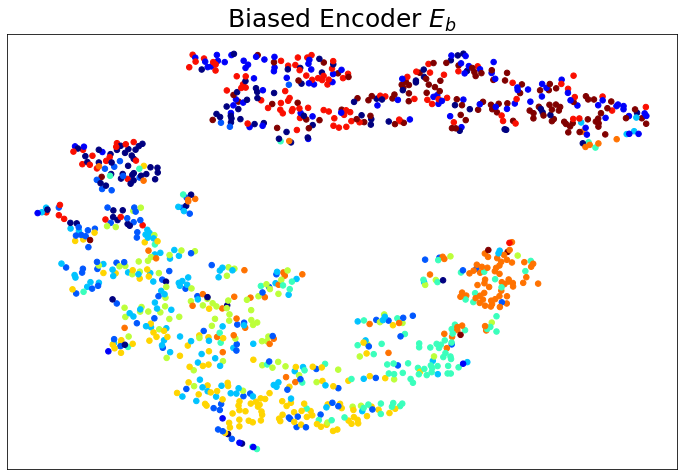

In [10]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, \
            cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 120, label = 'biased')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title('Biased Encoder $E_b$', fontsize = 25)
plt.savefig('figures/cifar10/wcl_biased.pdf', bbox_inches='tight')
plt.show()


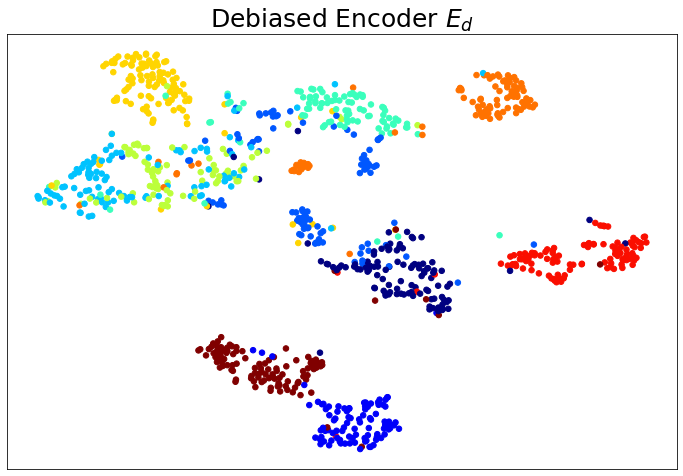

In [34]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, \
            cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 120, label = 'biased')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title('Debiased Encoder $E_d$', fontsize = 25)
plt.savefig('figures/cifar10/wcl_debiased.pdf', bbox_inches='tight')
plt.show()


### t-SNE debiased

In [18]:
data_iter = iter(test_loader)
feat, out, tar, biased = [], [], [], []

with torch.no_grad():
    for i in range(8):
        pos_1, pos_2, target = data_iter.next()
        pos_1 = pos_1.to(device)
        feature_1_b, out_1_b = model_b(pos_1)
        
        feat.append(feature_1_b.detach().cpu())
        out.append(out_1_b.detach().cpu())
        tar.append(target.detach().cpu())
        biased.append(torch.zeros_like(target))
    
feat = torch.cat(feat)
out = torch.cat(out)
tar = torch.cat(tar)
biased = torch.cat(biased)

In [19]:
tsne = TSNE(n_jobs=16)
embedded = tsne.fit_transform(out)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]
hard_group = 5

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


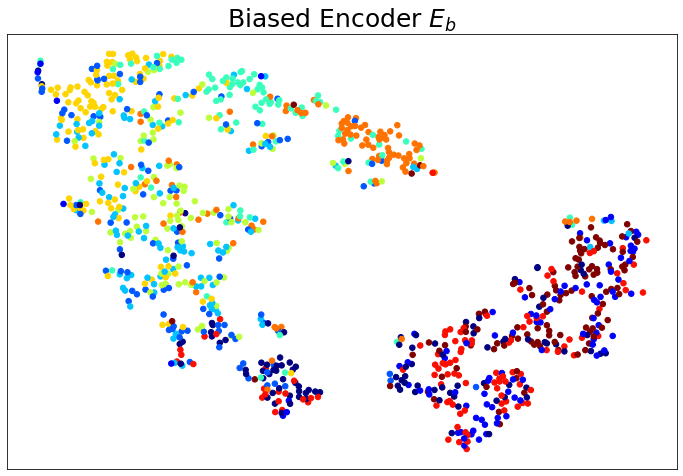

In [31]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, \
            cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 120, label = 'biased')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title('Biased Encoder $E_b$', fontsize = 25)
plt.savefig('figures/cifar10/wcl_biased.pdf', bbox_inches='tight')
plt.show()


### t-SNE together

In [10]:
data_iter = iter(test_loader)
feat, out, tar, biased = [], [], [], []

with torch.no_grad():
    for i in range(8):
        pos_1, pos_2, target = data_iter.next()
        pos_1 = pos_1.to(device)
        feature_1_d, out_1_d = model_d(pos_1)
        feature_1_b, out_1_b = model_b(pos_1)

        feat.append(feature_1_d.detach().cpu())
        out.append(out_1_d.detach().cpu())
        tar.append(target.detach().cpu())
        biased.append(torch.ones_like(target))
        
        feat.append(feature_1_b.detach().cpu())
        out.append(out_1_b.detach().cpu())
        tar.append(target.detach().cpu())
        biased.append(torch.zeros_like(target))
    
feat = torch.cat(feat)
out = torch.cat(out)
tar = torch.cat(tar)
biased = torch.cat(biased)

In [11]:
tsne = TSNE(n_jobs=16)
embedded = tsne.fit_transform(out)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]
hard_group = 5

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


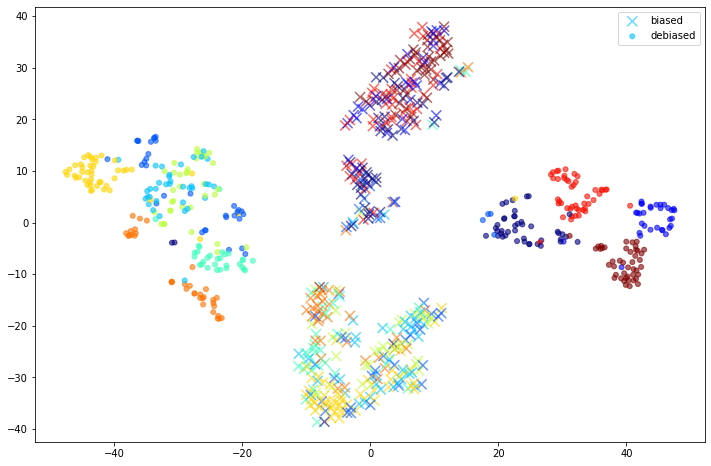

In [12]:


fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x[biased == 0], vis_y[biased == 0], c=tar[biased == 0], \
            cmap=plt.cm.get_cmap("jet", 20), marker='x', s = 100, alpha = 0.6, label = 'biased')
plt.scatter(vis_x[biased == 1], vis_y[biased == 1], c=tar[biased == 1], \
            cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 100, alpha = 0.6, label = 'debiased')
# plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c=tar[tar == hard_group], \
#             cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65, label = 'worst group')
# plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
#             marker='x', s = 150, lw = 3.5, label = 'worst group')
#plt.colorbar(ticks=range(10))
# plt.clim(-0.5, 9.5)
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


### t-SNE DCL

In [36]:
data_iter = iter(test_loader)
feat, out, tar, biased = [], [], [], []

with torch.no_grad():
    for i in range(8):
        pos_1, pos_2, target = data_iter.next()
        pos_1 = pos_1.to(device)
        feature_1_b, out_1_b = model_dcl(pos_1)
        
        feat.append(feature_1_b.detach().cpu())
        out.append(out_1_b.detach().cpu())
        tar.append(target.detach().cpu())
        biased.append(torch.zeros_like(target))
    
feat = torch.cat(feat)
out = torch.cat(out)
tar = torch.cat(tar)
biased = torch.cat(biased)

In [37]:
tsne = TSNE(n_jobs=16)
embedded = tsne.fit_transform(out)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]
hard_group = 5

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


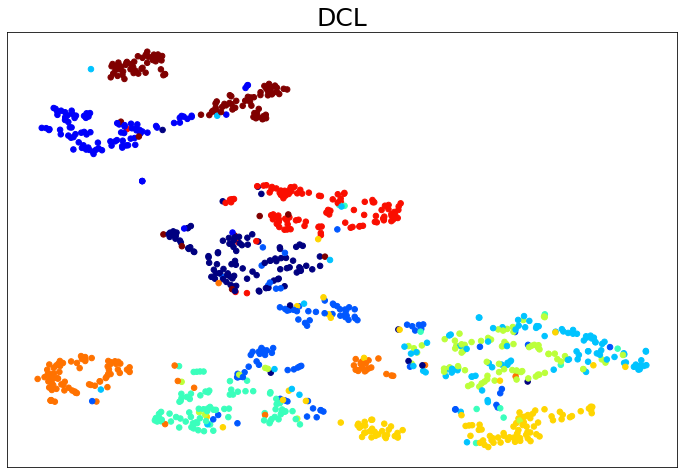

In [38]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, \
            cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 120, label = 'biased')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title('DCL', fontsize = 25)
plt.savefig('figures/cifar10/dcl.pdf', bbox_inches='tight')
plt.show()


### t-SNE debiased

In [39]:
data_iter = iter(test_loader)
feat, out, tar, biased = [], [], [], []

with torch.no_grad():
    for i in range(8):
        pos_1, pos_2, target = data_iter.next()
        pos_1 = pos_1.to(device)
        feature_1_b, out_1_b = model_hcl(pos_1)
        
        feat.append(feature_1_b.detach().cpu())
        out.append(out_1_b.detach().cpu())
        tar.append(target.detach().cpu())
        biased.append(torch.zeros_like(target))
    
feat = torch.cat(feat)
out = torch.cat(out)
tar = torch.cat(tar)
biased = torch.cat(biased)

In [41]:
tsne = TSNE(n_jobs=16)
embedded = tsne.fit_transform(out)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]
hard_group = 5

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


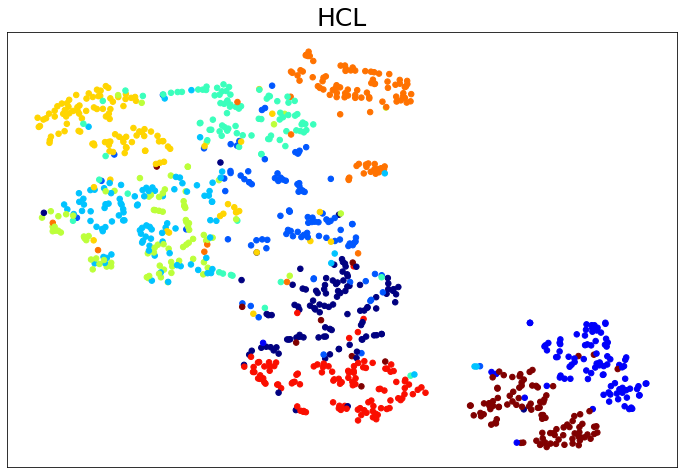

In [42]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, \
            cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 120, label = 'biased')
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title('HCL', fontsize = 25)
plt.savefig('figures/cifar10/hcl.pdf', bbox_inches='tight')
plt.show()


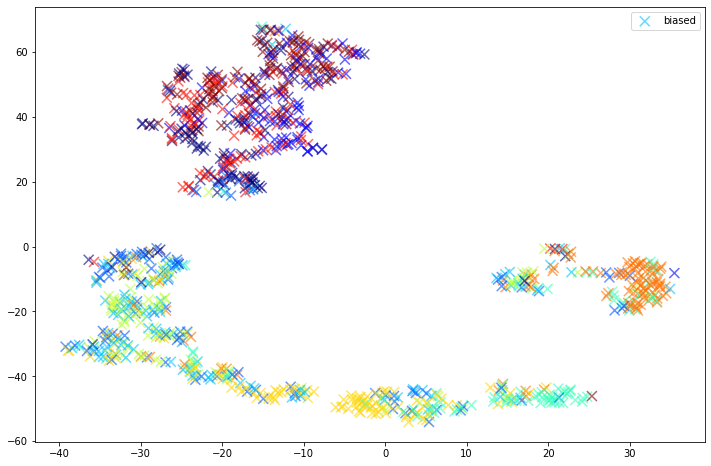

In [60]:


fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x[biased == 0], vis_y[biased == 0], c=tar[biased == 0], \
            cmap=plt.cm.get_cmap("jet", 20), marker='x', s = 100, alpha = 0.6, label = 'biased')
# plt.scatter(vis_x[biased == 1], vis_y[biased == 1], c=tar[biased == 1], \
#             cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 100, alpha = 0.6, label = 'debiased')
# plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c=tar[tar == hard_group], \
#             cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65, label = 'worst group')
# plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
#             marker='x', s = 150, lw = 3.5, label = 'worst group')
#plt.colorbar(ticks=range(10))
# plt.clim(-0.5, 9.5)
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


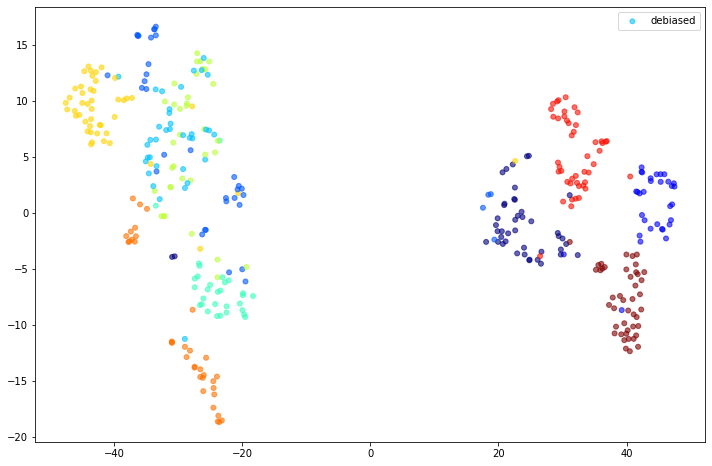

In [13]:


fig = plt.figure(figsize = (12,8))
# plt.scatter(vis_x[biased == 0], vis_y[biased == 0], c=tar[biased == 0], \
#             cmap=plt.cm.get_cmap("jet", 20), marker='x', s = 100, alpha = 0.6, label = 'biased')
plt.scatter(vis_x[biased == 1], vis_y[biased == 1], c=tar[biased == 1], \
            cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 100, alpha = 0.6, label = 'debiased')
# plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c=tar[tar == hard_group], \
#             cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65, label = 'worst group')
# plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
#             marker='x', s = 150, lw = 3.5, label = 'worst group')
#plt.colorbar(ticks=range(10))
# plt.clim(-0.5, 9.5)
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


In [67]:
hard_group = 5

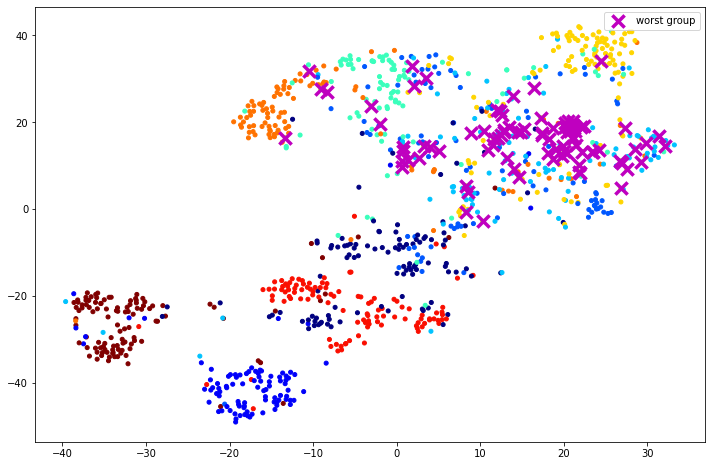

In [75]:

fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar[biased==1], cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65)
plt.scatter(vis_x[tar[biased==1] == hard_group], vis_y[tar[biased==1] == hard_group], c = 'm', \
            marker='x', s = 150, lw = 3.5, label = 'worst group')
#plt.colorbar(ticks=range(10))
# plt.clim(-0.5, 9.5)
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


In [ ]:
data_iter = iter(test_loader)
feat, out, tar = [], [], []

with torch.no_grad():
    for i in range(8):
        pos_1, pos_2, target = data_iter.next()
        pos_1 = pos_1.to(device)
        feature_1, out_1_d = model_d(pos_1)

        feat.append(feature_1.detach().cpu())
        out.append(out_1_d.detach().cpu())
        tar.append(target.detach().cpu())
    
feat = torch.cat(feat)
out = torch.cat(out)
tar = torch.cat(tar)

/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/taeuk/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


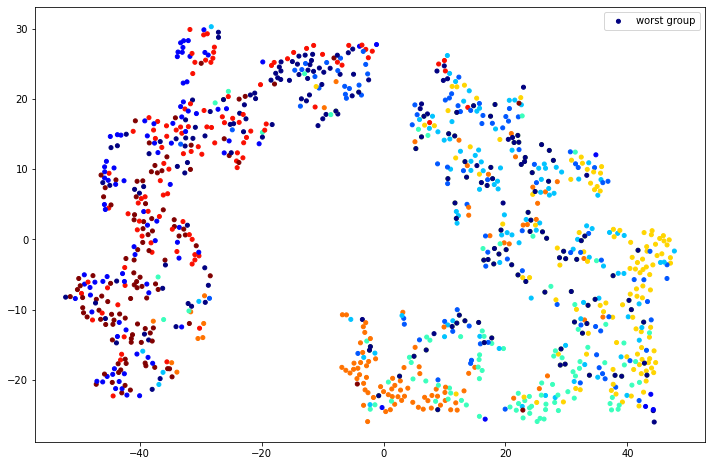

In [13]:
tsne = TSNE(n_jobs=16)
embedded = tsne.fit_transform(out)

vis_x = embedded[:, 0]
vis_y = embedded[:, 1]
hard_group = 5

fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65)
plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c=tar[tar == hard_group], \
            cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65, label = 'worst group')
# plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
#             marker='x', s = 150, lw = 3.5, label = 'worst group')
#plt.colorbar(ticks=range(10))
# plt.clim(-0.5, 9.5)
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


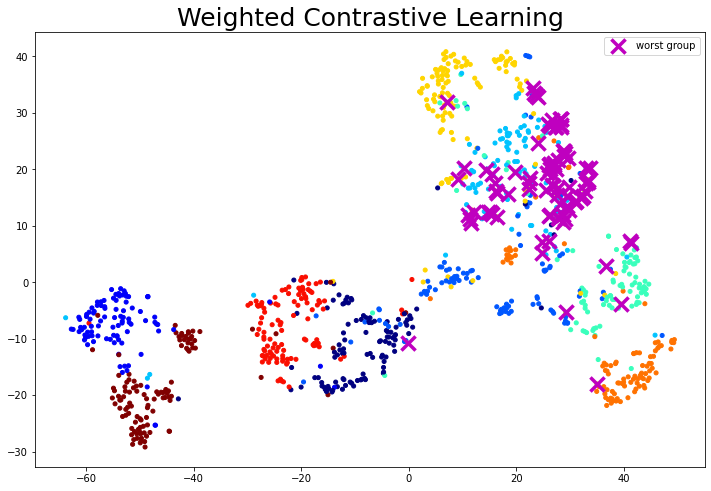

In [68]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65)
plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
            marker='x', s = 200, lw = 3.5, label = 'worst group')
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


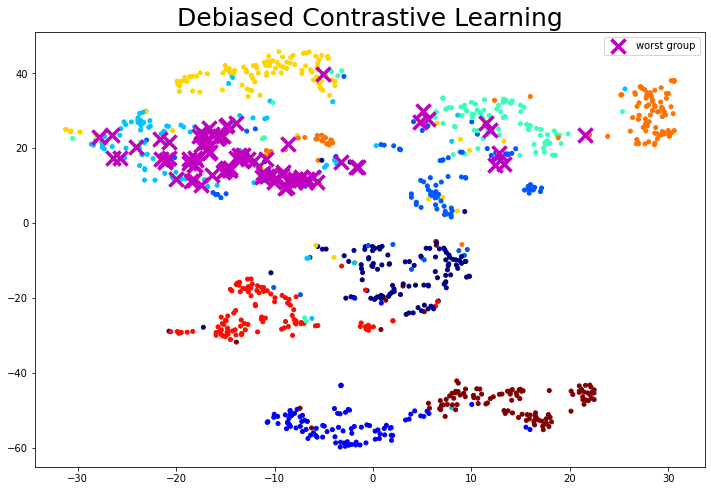

In [76]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65)
plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
            marker='x', s = 200, lw = 3.5, label = 'worst group')
plt.legend()

plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

# plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


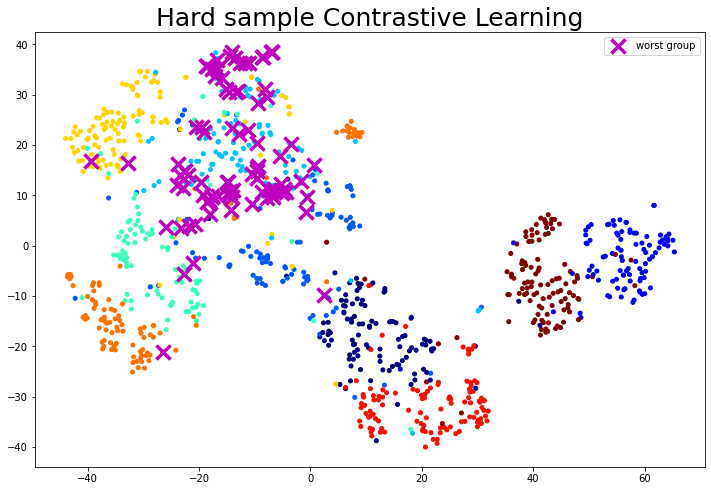

In [72]:
fig = plt.figure(figsize = (12,8))
plt.scatter(vis_x, vis_y, c=tar, cmap=plt.cm.get_cmap("jet", 20), marker='.', s = 65)
plt.scatter(vis_x[tar == hard_group], vis_y[tar == hard_group], c = 'm', \
            marker='x', s = 200, lw = 3.5, label = 'worst group')
plt.legend()

# plt.title('Debiased Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/DCL.pdf', bbox_inches='tight')

plt.title('Hard sample Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/HCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning', fontsize = 25)
# plt.savefig('figures/cifar10/WCL.pdf', bbox_inches='tight')

# plt.title('Weighted Contrastive Learning ($E_b$)', fontsize = 25n)
# plt.savefig('figures/cifar10/WCL(b).pdf', bbox_inches='tight')

plt.show()


In [26]:
import pickle 
pickle.load( open( '../results/summary_dcl.pkl', "rb" ))

{'train_loss': [1.352896473197937,
  0.6573573044776917,
  0.5230751333236694,
  0.4771652105998993,
  0.4564253346824646,
  0.44057649498939516,
  0.4323976421642303,
  0.4248136029911041,
  0.4210838715171814,
  0.41998688117027283,
  0.41457284764289853,
  0.40812781759262085,
  0.41131137600898743,
  0.4096531489086151,
  0.4029350093841553,
  0.4005132156944275,
  0.400172165555954,
  0.3928316573619843,
  0.39728879360198976,
  0.39885678647994993,
  0.39133828516960145,
  0.39839599944114684,
  0.3986996331882477,
  0.3935649960803986,
  0.39344157689094544,
  0.3857441089344025,
  0.39392248525619505,
  0.3861663512229919,
  0.3835730926895142,
  0.38330222647666934],
 'train_acc@1': [81.572,
  84.50999999999999,
  85.184,
  85.596,
  85.802,
  85.938,
  86.09599999999999,
  86.162,
  86.194,
  86.18400000000001,
  86.454,
  86.516,
  86.572,
  86.316,
  86.666,
  86.572,
  86.866,
  87.008,
  86.82600000000001,
  86.72999999999999,
  86.992,
  86.7,
  86.69200000000001,
  86.8

In [12]:
def get_negative_mask(batch_size):
    negative_mask = torch.ones((batch_size, 2 * batch_size), dtype=bool)
    for i in range(batch_size):
        negative_mask[i, i] = 0
        negative_mask[i, i + batch_size] = 0

    negative_mask = torch.cat((negative_mask, negative_mask), 0)
    return negative_mask

def triplet(out_1,out_2,batch_size):
    #biased representation learning
    out = torch.cat([out_1, out_2], dim=0) # 2 * bs x fs
    s = torch.pow(out.unsqueeze(0) - out.unsqueeze(1), 2).sum(-1)
    
    mask = get_negative_mask(batch_size).to(device)
    s = s.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, bs - 2) : subtract self and its augment

    pos = torch.pow(out_1 - out_2, 2).mean()
    neg = s.mean()

    return torch.clamp(pos - neg + 3, min = 0)

def W(out_d, out_b, batch_size):
    mask = get_negative_mask(batch_size).to(device)
    
    s_d =  torch.pow(out_d.unsqueeze(0) - out_d.unsqueeze(1), 2).sum(-1)
    s_d = s_d.masked_select(mask).view(2 * batch_size, -1)
    s_b =  torch.pow(out_b.unsqueeze(0) - out_b.unsqueeze(1), 2).sum(-1)
    s_b = s_b.masked_select(mask).view(2 * batch_size, -1)
    
    weight = 1 + s_d / (s_b + s_d)
#     print(weight)
    
    return weight
    
def orientation(out_1_d,out_2_d,out_1_b,out_2_b,batch_size):
    #space sharing
    out_d = torch.cat([out_1_d,out_2_d], dim=0)
    out_b = torch.cat([out_1_b,out_2_b], dim=0)
#     print(out_d)
#     print(out_b)
#     print(nn.MSELoss(reduction = 'sum')(out_d, out_b)/batch_size)
    return nn.MSELoss(reduction = 'sum')(out_d, out_b)/batch_size
    
    
def criterion(out_1_d, out_2_d, out_1_b, out_2_b, tau_plus, batch_size, beta, estimator, temperature):
    # neg score
    out = torch.cat([out_1_d, out_2_d], dim=0)
    out_b = torch.cat([out_1_b, out_2_b], dim=0)
    neg = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    old_neg = neg.clone()
    mask = get_negative_mask(batch_size).to(device)
    neg = neg.masked_select(mask).view(2 * batch_size, -1) # (2 * bs, bs - 2) : subtract self and its augment

    # pos score
    pos = torch.exp(torch.sum(out_1_d * out_2_d, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    
    weight = W(out, out_b, batch_size) # (2 * bs, bs - 2)

    # negative samples similarity scoring
    if estimator=='hard':
        N = batch_size * 2 - 2
#         imp = (beta* neg.log()).exp()
#         reweight_neg = (imp*neg).sum(dim = -1) / imp.mean(dim = -1)
        reweight_neg = weight * neg
        
        Ng = (-tau_plus * N * pos + reweight_neg.sum(dim = -1)) / (1 - tau_plus)
        # constrain (optional)
        Ng = torch.clamp(Ng, min = N * np.e**(-1 / temperature))
    elif estimator=='easy':
        Ng = neg.sum(dim=-1)
    else:
        raise Exception('Invalid estimator selected. Please use any of [hard, easy]')

    # contrastive loss
    loss = (- torch.log(pos / (pos + Ng) )).mean()

    return loss